### Dwie instancje - 5s

In [5]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://464979-loadbalancer-af7b87d5a8a2b254.elb.us-east-1.amazonaws.com:8080"


UNIT = 5.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 4	mean time: 0.310s	fast	
INFO:root:Thread: 0	reqs: 4	mean time: 0.291s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.264s	
INFO:root:Thread: 0	reqs: 2	mean time: 0.807s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.192s	
INFO:root:Thread: 0	reqs: 2	mean time: 0.889s	fast	
INFO:root:Thread: 2	reqs: 2	mean time: 1.207s	
INFO:root:Thread: 0	reqs: 2	mean time: 1.014s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.276s	
INFO:root:Thread: 2	reqs: 2	mean time: 1.217s	
INFO:root:Thread: 3	reqs: 1	mean time: 2.238s	
INFO:root:Thread: 0	reqs: 2	mean time: 1.830s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.373s	
INFO:root:Thread: 2	reqs: 2	mean time: 1.577s	
INFO:root:Thread: 3	reqs: 2	mean time: 1.599s	
INFO:root:Thread: 4	reqs: 1	mean time: 2.513s	
INFO:root:Thread: 1	reqs: 2	mean time: 2.082s	
INFO:root:Thread: 0	reqs: 2	mean time: 1.520s	fast	
INFO:root:Thread: 2	reqs: 1	mean time: 3.425s	
INFO:root:Thread: 3	reqs: 2	mean time: 1.823s	
INFO:root:Thread: 1	reqs:

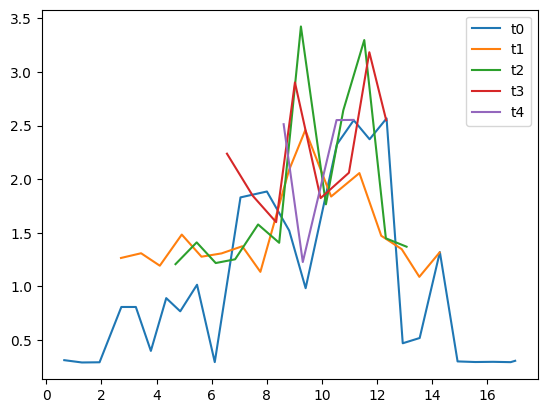

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()

### Dwie instancje - 60s

In [1]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://464979-1-LoadBalancer-69cc70eab93f0b76.elb.us-east-1.amazonaws.com:8080"


UNIT = 60.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 38	mean time: 0.298s	fast	
INFO:root:Thread: 0	reqs: 38	mean time: 0.296s	fast	
INFO:root:Thread: 1	reqs: 18	mean time: 1.230s	
INFO:root:Thread: 0	reqs: 24	mean time: 0.787s	fast	
INFO:root:Thread: 1	reqs: 18	mean time: 1.196s	
INFO:root:Thread: 0	reqs: 28	mean time: 0.624s	fast	
INFO:root:Thread: 2	reqs: 17	mean time: 1.314s	
INFO:root:Thread: 1	reqs: 17	mean time: 1.358s	
INFO:root:Thread: 0	reqs: 25	mean time: 0.732s	fast	
INFO:root:Thread: 2	reqs: 17	mean time: 1.290s	
INFO:root:Thread: 1	reqs: 17	mean time: 1.292s	
INFO:root:Thread: 0	reqs: 26	mean time: 0.714s	fast	
INFO:root:Thread: 3	reqs: 14	mean time: 1.792s	
INFO:root:Thread: 2	reqs: 15	mean time: 1.542s	
INFO:root:Thread: 1	reqs: 15	mean time: 1.573s	
INFO:root:Thread: 0	reqs: 17	mean time: 1.279s	fast	
INFO:root:Thread: 3	reqs: 15	mean time: 1.578s	
INFO:root:Thread: 2	reqs: 14	mean time: 1.649s	
INFO:root:Thread: 1	reqs: 15	mean time: 1.591s	
INFO:root:Thread: 0	reqs: 20	mean time: 1.126s	fast	


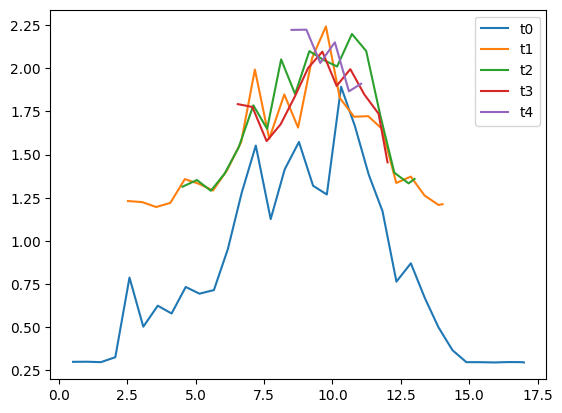

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()

### Skalowanie bez odczekania - 45s

In [1]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://464979-LoadBalancer-272a50d718ade55d.elb.us-east-1.amazonaws.com:8080"


UNIT = 45.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 28	mean time: 0.297s	fast	
INFO:root:Thread: 0	reqs: 28	mean time: 0.299s	fast	
INFO:root:Thread: 0	reqs: 23	mean time: 0.477s	fast	
INFO:root:Thread: 1	reqs: 13	mean time: 1.274s	
INFO:root:Thread: 0	reqs: 23	mean time: 0.503s	fast	
INFO:root:Thread: 1	reqs: 14	mean time: 1.211s	
INFO:root:Thread: 2	reqs: 13	mean time: 1.349s	
INFO:root:Thread: 0	reqs: 20	mean time: 0.642s	fast	
INFO:root:Thread: 1	reqs: 13	mean time: 1.374s	
INFO:root:Thread: 2	reqs: 12	mean time: 1.442s	
INFO:root:Thread: 0	reqs: 16	mean time: 0.900s	fast	
INFO:root:Thread: 1	reqs: 12	mean time: 1.411s	
INFO:root:Thread: 3	reqs: 9	mean time: 1.992s	
INFO:root:Thread: 0	reqs: 17	mean time: 0.848s	fast	
INFO:root:Thread: 2	reqs: 10	mean time: 1.906s	
INFO:root:Thread: 1	reqs: 12	mean time: 1.553s	
INFO:root:Thread: 3	reqs: 10	mean time: 1.784s	
INFO:root:Thread: 0	reqs: 18	mean time: 0.804s	fast	
INFO:root:Thread: 2	reqs: 12	mean time: 1.586s	
INFO:root:Thread: 1	reqs: 11	mean time: 1.549s	
I

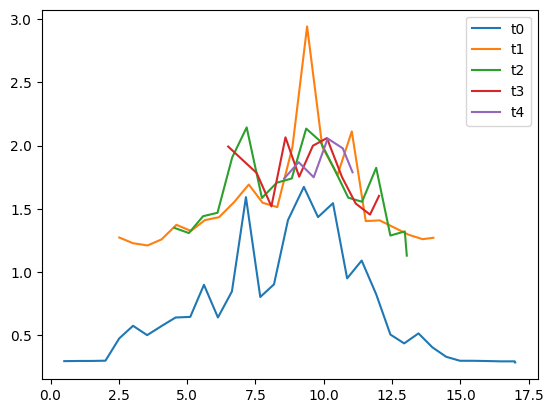

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()

### Skalowanie z odczekaniem - 60s

In [1]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://464979-LoadBalancer-0165784e7aab6ce5.elb.us-east-1.amazonaws.com:8080"


UNIT = 60.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 38	mean time: 0.295s	fast	
INFO:root:Thread: 0	reqs: 38	mean time: 0.297s	fast	
INFO:root:Thread: 1	reqs: 18	mean time: 1.198s	
INFO:root:Thread: 0	reqs: 28	mean time: 0.591s	fast	
INFO:root:Thread: 1	reqs: 17	mean time: 1.272s	
INFO:root:Thread: 0	reqs: 27	mean time: 0.619s	fast	
INFO:root:Thread: 2	reqs: 18	mean time: 1.263s	
INFO:root:Thread: 1	reqs: 17	mean time: 1.281s	
INFO:root:Thread: 0	reqs: 26	mean time: 0.689s	fast	
INFO:root:Thread: 2	reqs: 16	mean time: 1.433s	
INFO:root:Thread: 1	reqs: 16	mean time: 1.415s	
INFO:root:Thread: 0	reqs: 27	mean time: 0.628s	fast	
INFO:root:Thread: 3	reqs: 14	mean time: 1.734s	
INFO:root:Thread: 2	reqs: 16	mean time: 1.501s	
INFO:root:Thread: 1	reqs: 16	mean time: 1.449s	
INFO:root:Thread: 0	reqs: 17	mean time: 1.343s	fast	
INFO:root:Thread: 3	reqs: 15	mean time: 1.594s	
INFO:root:Thread: 2	reqs: 15	mean time: 1.500s	
INFO:root:Thread: 0	reqs: 21	mean time: 0.930s	fast	
INFO:root:Thread: 1	reqs: 16	mean time: 1.477s	


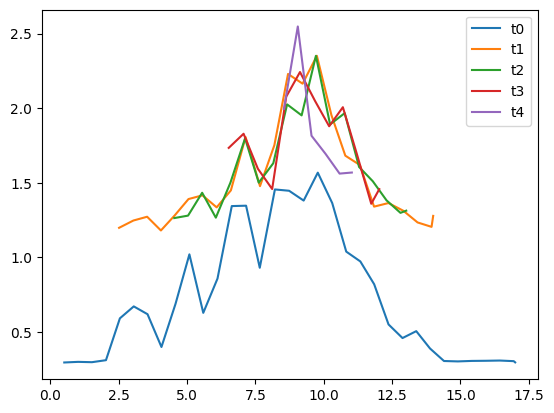

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()

### Skalowanie z odczekaniem - 5s

In [1]:
import requests
import random
import math
import time
import threading
import logging
logging.getLogger().setLevel(logging.INFO)


API_URL="http://464979-LoadBalancer-0165784e7aab6ce5.elb.us-east-1.amazonaws.com:8080"


UNIT = 5.0 # secs

# Pre generated primes
first_primes_list = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29,
                     31, 37, 41, 43, 47, 53, 59, 61, 67,
                     71, 73, 79, 83, 89, 97, 101, 103,
                     107, 109, 113, 127, 131, 137, 139,
                     149, 151, 157, 163, 167, 173, 179,
                     181, 191, 193, 197, 199, 211, 223,
                     227, 229, 233, 239, 241, 251, 257,
                     263, 269, 271, 277, 281, 283, 293,
                     307, 311, 313, 317, 331, 337, 347, 349]


def nBitRandom(n):
    return random.randrange(2**(n-1)+1, 2**n - 1)
 
def getLowLevelPrime(n):
    '''Generate a prime candidate divisible
    by first primes'''
    while True:
        # Obtain a random number
        pc = nBitRandom(n)
 
         # Test divisibility by pre-generated
         # primes
        for divisor in first_primes_list:
            if pc % divisor == 0 and divisor**2 <= pc:
                break
        else: return pc
 
def isMillerRabinPassed(mrc):
    '''Run 20 iterations of Rabin Miller Primality test'''
    maxDivisionsByTwo = 0
    ec = mrc-1
    while ec % 2 == 0:
        ec >>= 1
        maxDivisionsByTwo += 1
    assert(2**maxDivisionsByTwo * ec == mrc-1)
 
    def trialComposite(round_tester):
        if pow(round_tester, ec, mrc) == 1:
            return False
        for i in range(maxDivisionsByTwo):
            if pow(round_tester, 2**i * ec, mrc) == mrc-1:
                return False
        return True
 
    # Set number of trials here
    numberOfRabinTrials = 20
    for i in range(numberOfRabinTrials):
        round_tester = random.randrange(2, mrc)
        if trialComposite(round_tester):
            return False
    return True
 
def random_large_prime(bits):
    while True:
        prime_candidate = getLowLevelPrime(bits)
        if not isMillerRabinPassed(prime_candidate):
            continue
        else:
            return prime_candidate

def thread_function(i, fast, timeout):
    start = time.time()

    c = 5 # bits: 20: 200ms; 21: 350ms; 22: 700ms  23: 1.5s; 25: 6s; 26: 10s; 27: 24s
    bits = 19 if fast else 23
    last_report = time.time()
    processing_time = 0.0
    reqs = 0
    while True:
        iter_start = time.time()
        if iter_start - start > timeout:
            logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            return
        if iter_start - last_report > UNIT/2:
            if len(results[i])%2 == 0:
                logging.info("Thread: %d\treqs: %d\tmean time: %.3fs\t%s"%(i, reqs, processing_time/reqs if reqs>0 else 0.0, "fast\t" if fast else ""))
            results[i][iter_start] = processing_time/reqs if reqs>0 else 0.0
            processing_time = 0.0
            reqs = 0
            last_report=iter_start

        factors = [random_large_prime(bits) for i in range(c)]
        factors.sort()
        n=math.prod(factors)

        r = requests.get(API_URL+'/factors/%d'%(n))
        if r.status_code != 200:
            logging.error("wrong status code from webservice")
        else:
            result = r.json()
            if result != factors:
                logging.error("Wrong factors")

        processing_time+=time.time() - iter_start
        reqs+=1
        time.sleep(0.5)

START = time.time()
slow_threads = 4

results = [ {} for i in range(slow_threads+1)]

t0 = threading.Thread(target=thread_function, args=(0, True, (5 + slow_threads*3) * UNIT))
t0.start()
time.sleep(2 * UNIT)
for i in range(slow_threads):
    t = threading.Thread(target=thread_function, args=(i+1, False, (slow_threads-i) * 3 * UNIT))
    t.start()
    time.sleep(2 * UNIT)

t0.join()

INFO:root:Thread: 0	reqs: 4	mean time: 0.308s	fast	
INFO:root:Thread: 0	reqs: 4	mean time: 0.319s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.326s	
INFO:root:Thread: 0	reqs: 2	mean time: 0.753s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.457s	
INFO:root:Thread: 0	reqs: 4	mean time: 0.471s	fast	
INFO:root:Thread: 2	reqs: 2	mean time: 1.283s	
INFO:root:Thread: 1	reqs: 2	mean time: 1.054s	
INFO:root:Thread: 2	reqs: 2	mean time: 1.159s	
INFO:root:Thread: 0	reqs: 3	mean time: 0.636s	fast	
INFO:root:Thread: 3	reqs: 2	mean time: 1.484s	
INFO:root:Thread: 2	reqs: 1	mean time: 2.007s	
INFO:root:Thread: 0	reqs: 2	mean time: 0.784s	fast	
INFO:root:Thread: 1	reqs: 2	mean time: 1.343s	
INFO:root:Thread: 3	reqs: 2	mean time: 1.404s	
INFO:root:Thread: 4	reqs: 1	mean time: 2.357s	
INFO:root:Thread: 0	reqs: 2	mean time: 1.212s	fast	
INFO:root:Thread: 2	reqs: 2	mean time: 1.852s	
INFO:root:Thread: 1	reqs: 2	mean time: 1.634s	
INFO:root:Thread: 3	reqs: 1	mean time: 2.103s	
INFO:root:Thread: 0	reqs:

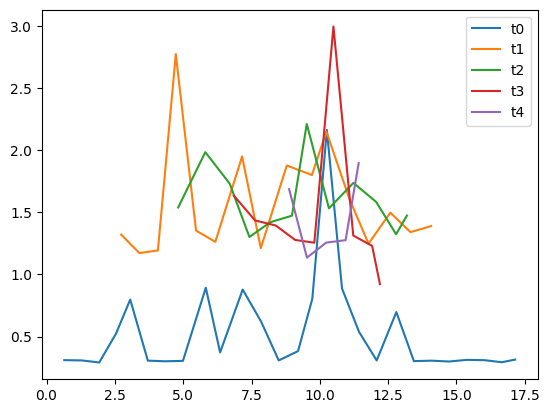

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
mu = 0
std = 1
for i, result in enumerate(results):
    x = [(x - START)/UNIT for x in result.keys()]
    y = result.values()
    plt.plot(x, y, label="t%d"%(i,))

plt.legend()
plt.show()